In [15]:
import matplotlib.pyplot as plt
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

I did not implemented wandb here because I do not want to 😂😜😜

# Dataset_Preparation and Sampling

In [16]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 15
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

In [17]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [18]:
summary(models.densenet121())

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

In [19]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights)
        # Change the final conv layer to match 5 flower dataset
        self.base_model.classifier = nn.Linear(in_features=1024, out_features=5)
        # Freeze the feature layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Unsqeeze the final layer only 
        for param in self.base_model.classifier.parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.base_model(x)
        return x

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DenseNet().to(device)
summary(model)  # Great way to look overall what is happening inside your model

Layer (type:depth-idx)                        Param #
DenseNet                                      --
├─DenseNet: 1-1                               --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (9,408)
│    │    └─BatchNorm2d: 3-2                  (128)
│    │    └─ReLU: 3-3                         --
│    │    └─MaxPool2d: 3-4                    --
│    │    └─_DenseBlock: 3-5                  (335,040)
│    │    └─_Transition: 3-6                  (33,280)
│    │    └─_DenseBlock: 3-7                  (919,680)
│    │    └─_Transition: 3-8                  (132,096)
│    │    └─_DenseBlock: 3-9                  (2,837,760)
│    │    └─_Transition: 3-10                 (526,336)
│    │    └─_DenseBlock: 3-11                 (2,158,080)
│    │    └─BatchNorm2d: 3-12                 (2,048)
│    └─Linear: 2-2                            5,125
Total params: 6,958,981
Trainable params: 5,125
Non-trainable params: 6,953,856

## Correct and optimised training loop

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/15] | Loss: 0.7352 | Train Acc: 0.7574 | Val Acc: 0.8794
Epoch [2/15] | Loss: 0.4351 | Train Acc: 0.8570 | Val Acc: 0.8794
Epoch [3/15] | Loss: 0.3754 | Train Acc: 0.8752 | Val Acc: 0.8840
Epoch [4/15] | Loss: 0.3366 | Train Acc: 0.8816 | Val Acc: 0.8863
Epoch [5/15] | Loss: 0.3104 | Train Acc: 0.8923 | Val Acc: 0.8933
Epoch [6/15] | Loss: 0.2932 | Train Acc: 0.9010 | Val Acc: 0.8910
Epoch [7/15] | Loss: 0.3019 | Train Acc: 0.8937 | Val Acc: 0.8863
Epoch [8/15] | Loss: 0.2914 | Train Acc: 0.8955 | Val Acc: 0.8979
Epoch [9/15] | Loss: 0.2637 | Train Acc: 0.9079 | Val Acc: 0.8979
Epoch [10/15] | Loss: 0.2554 | Train Acc: 0.9117 | Val Acc: 0.9002
Epoch [11/15] | Loss: 0.2508 | Train Acc: 0.9146 | Val Acc: 0.8979
Epoch [12/15] | Loss: 0.2630 | Train Acc: 0.9036 | Val Acc: 0.8910
Epoch [13/15] | Loss: 0.2522 | Train Acc: 0.9108 | Val Acc: 0.9072
Epoch [14/15] | Loss: 0.2396 | Train Acc: 0.9117 | Val Acc: 0.9049
Epoch [15/15] | Loss: 0.2428 | Train Acc: 0.9114 | Val Acc: 0.8956


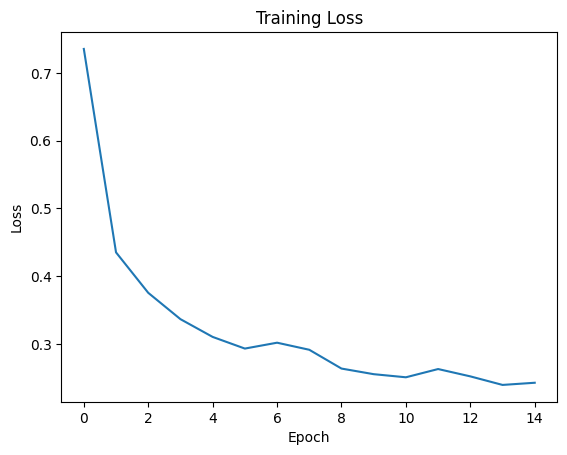

In [25]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

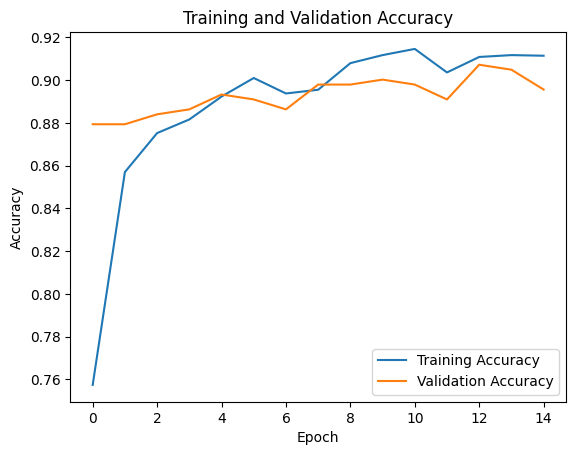

In [26]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [27]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.8958
Final train Accuracy: 0.9114
Final validation Accuracy: 0.8956
